In [1]:
import os
os.environ["DEVELOPMENT"] = '1'

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent,IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath
import pandas as pd
import numpy as np

INFO:root:Running the simulation in development mode.
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
C:\Users\tygt1\anaconda3\lib\site-packages\setuptools\_distutils\_msvccompiler.py:563: UserWarning: Fallback spawn triggered. Please update distutils monkeypatch.
  warnings.warn("Fallback spawn triggered. Please update distutils monkeypatch.")


## Soil fertility calibration

In [2]:
weather_file_path = get_filepath('brussels_climate.txt')

In [6]:
Rel=60
RedaCCx=74
CCx=92

IrrMethod=0
stress=23#give the value shown in AquaCrop-windows interface for test

In [7]:
irrMet=IrrigationManagement(irrigation_method=IrrMethod,NetIrrSMT=80)

wheat = Crop('PotatoGDDAQTEST', planting_date='05/01',need_calib=1,RelativeBio=Rel/100,Ksccx_in=RedaCCx/CCx,fcdecline_in=1,
            sfertstress=stress/100)

model_os = AquaCropModel(
            sim_start_time=f'{1976}/05/01',
            sim_end_time=f'{1976}/07/24',
            weather_df=prepare_weather(weather_file_path),
            soil=Soil(soil_type='SandyLoam'),
            crop=wheat,
            initial_water_content=InitialWaterContent(value=['FC']),
            irrigation_management=irrMet
        )
model_os.run_model(till_termination=True)
model_results = model_os.get_crop_growth()

------
DatetimeIndex(['1976-05-01', '1976-05-02', '1976-05-03', '1976-05-04',
               '1976-05-05', '1976-05-06', '1976-05-07', '1976-05-08',
               '1976-05-09', '1976-05-10', '1976-05-11', '1976-05-12',
               '1976-05-13', '1976-05-14', '1976-05-15', '1976-05-16',
               '1976-05-17', '1976-05-18', '1976-05-19', '1976-05-20',
               '1976-05-21', '1976-05-22', '1976-05-23', '1976-05-24',
               '1976-05-25', '1976-05-26', '1976-05-27', '1976-05-28',
               '1976-05-29', '1976-05-30', '1976-05-31', '1976-06-01',
               '1976-06-02', '1976-06-03', '1976-06-04', '1976-06-05',
               '1976-06-06', '1976-06-07', '1976-06-08', '1976-06-09',
               '1976-06-10', '1976-06-11', '1976-06-12', '1976-06-13',
               '1976-06-14', '1976-06-15', '1976-06-16', '1976-06-17',
               '1976-06-18', '1976-06-19', '1976-06-20', '1976-06-21',
               '1976-06-22', '1976-06-23', '1976-06-24', '1976-06-25',

E:\OneDrive - University of Twente\WaterResearch\AquaCrop\AqOSv7\AQv7\aquacrop\solution\biomass_accumulation.py:136: RuntimeWarning: invalid value encountered in double_scalars
  BioAdj=FracBiomassPotSF+FracBiomassPotSF-NewCond_B/(Crop.Bio_top[NewCond_DAP]*WPadj)


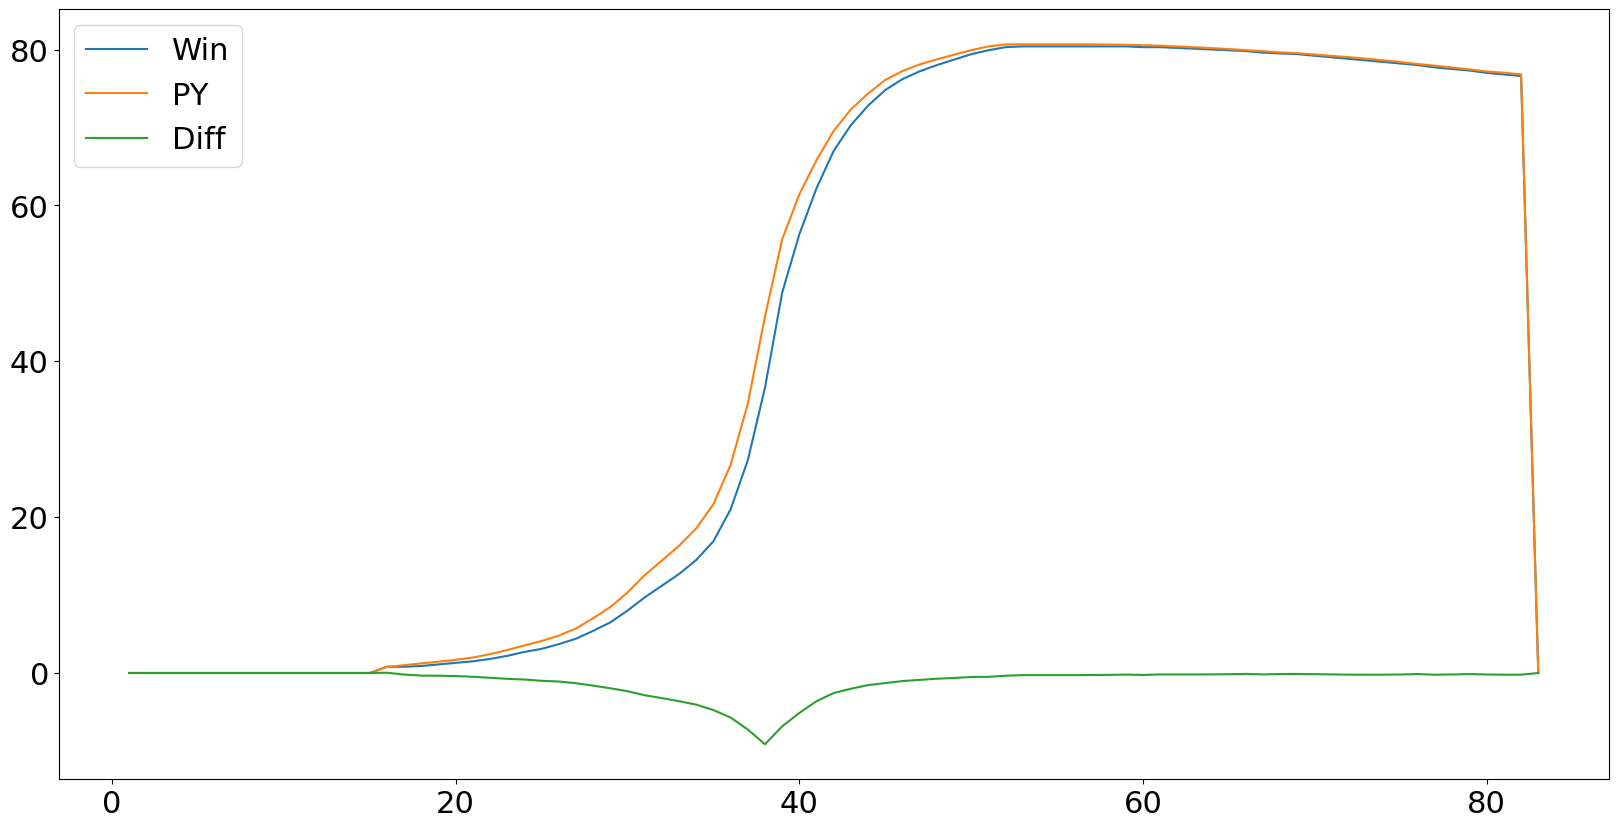

<Figure size 640x480 with 0 Axes>

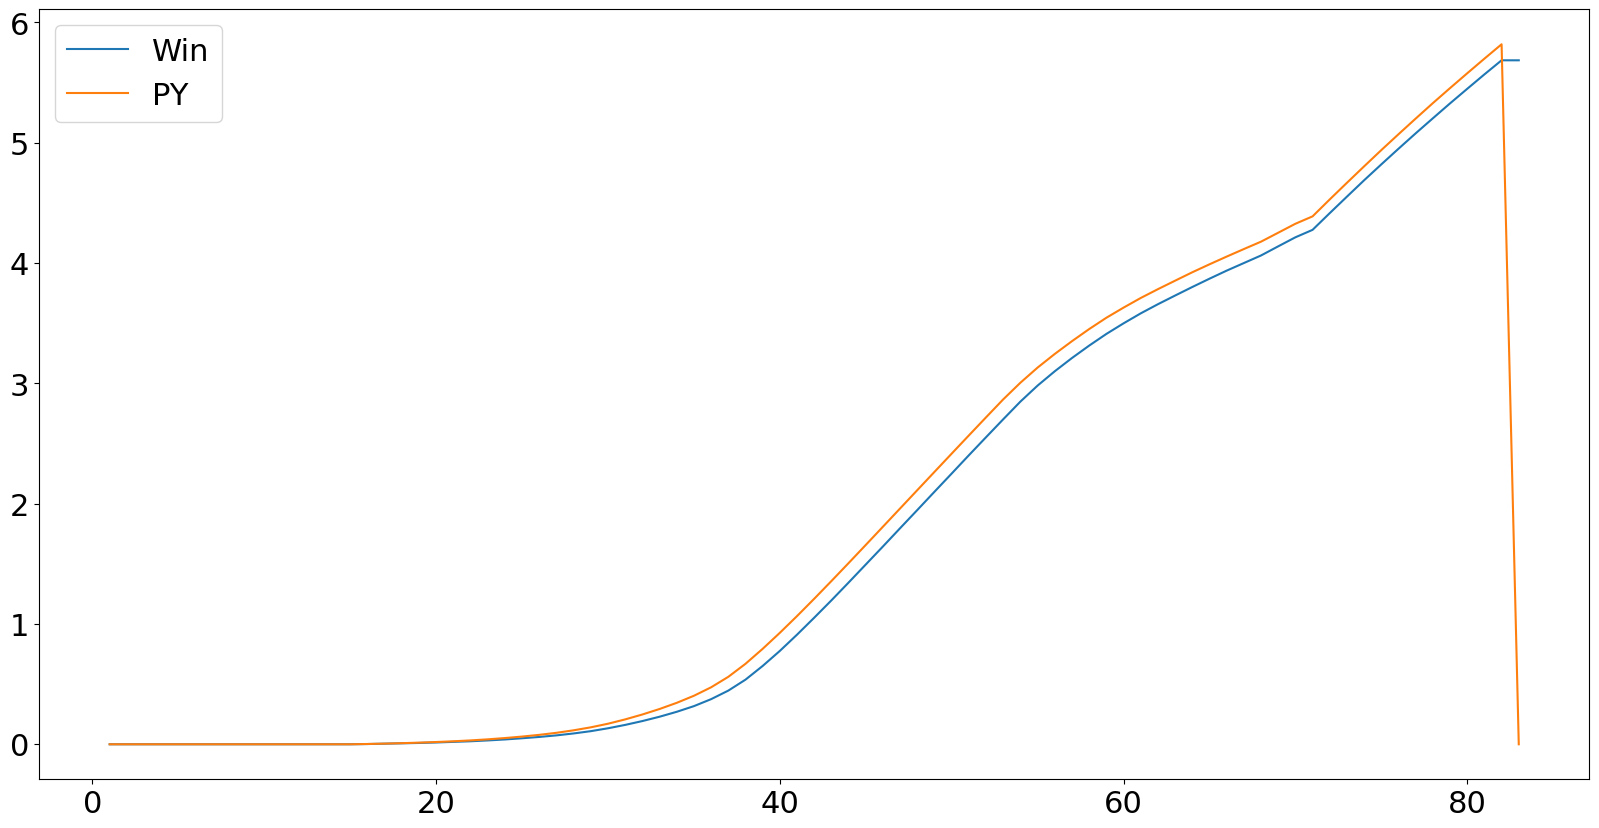

<Figure size 640x480 with 0 Axes>

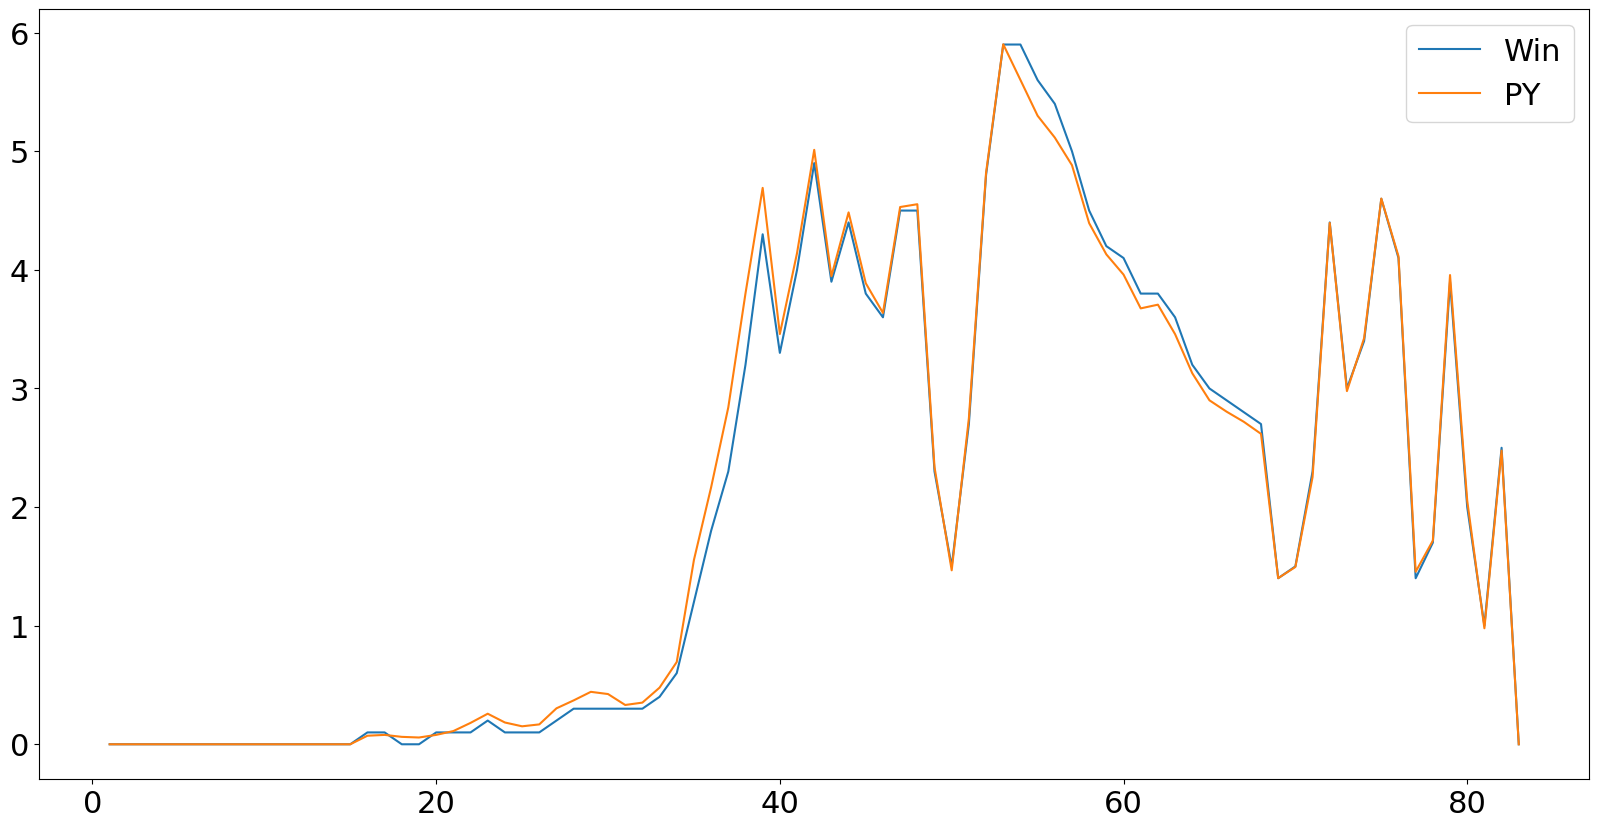

<Figure size 640x480 with 0 Axes>

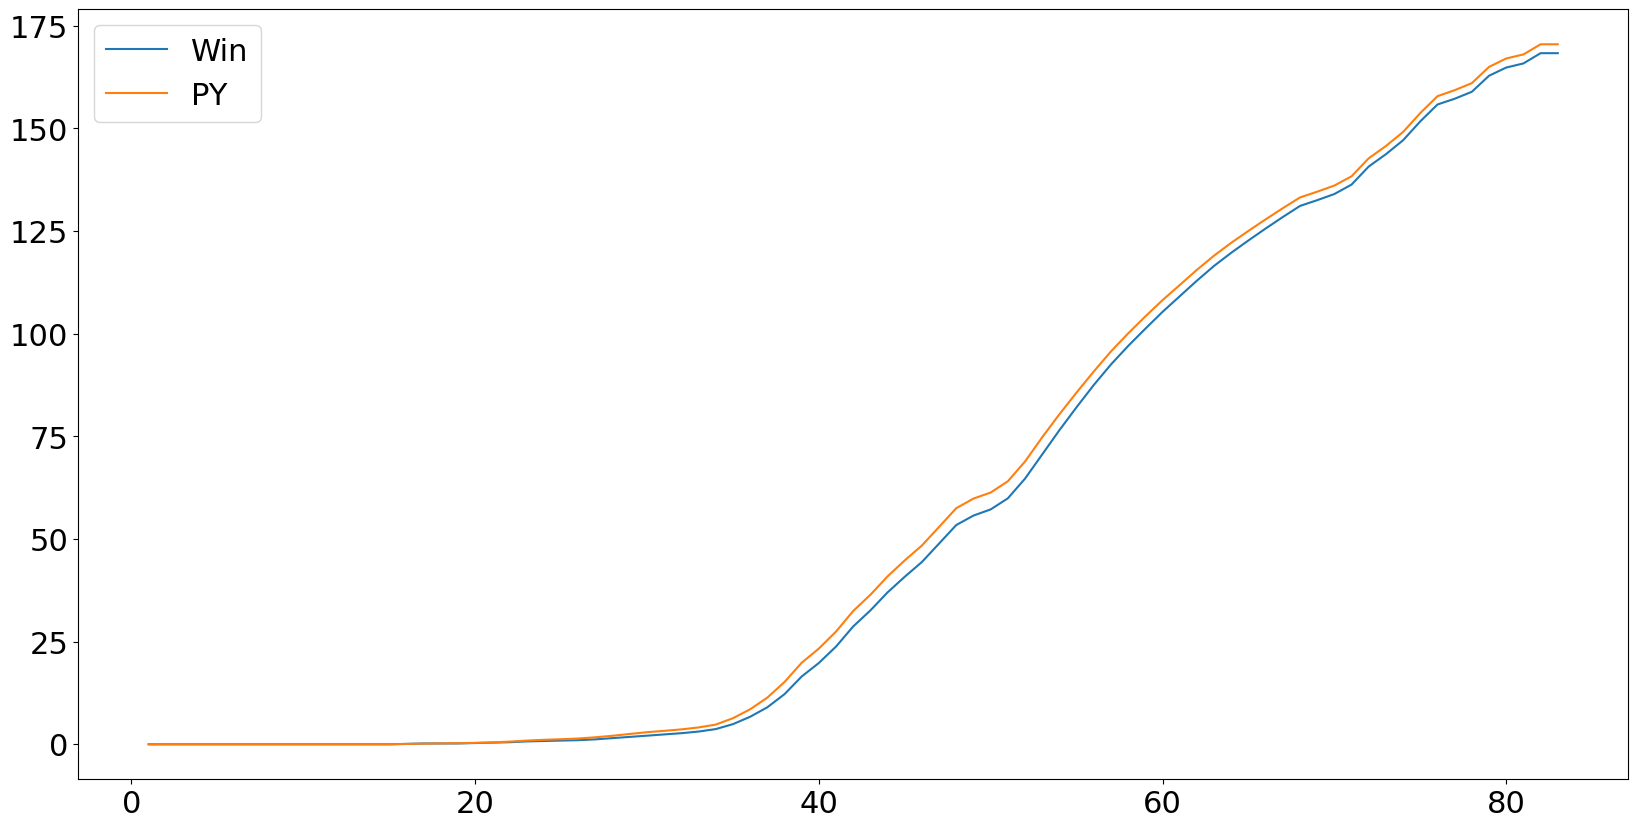

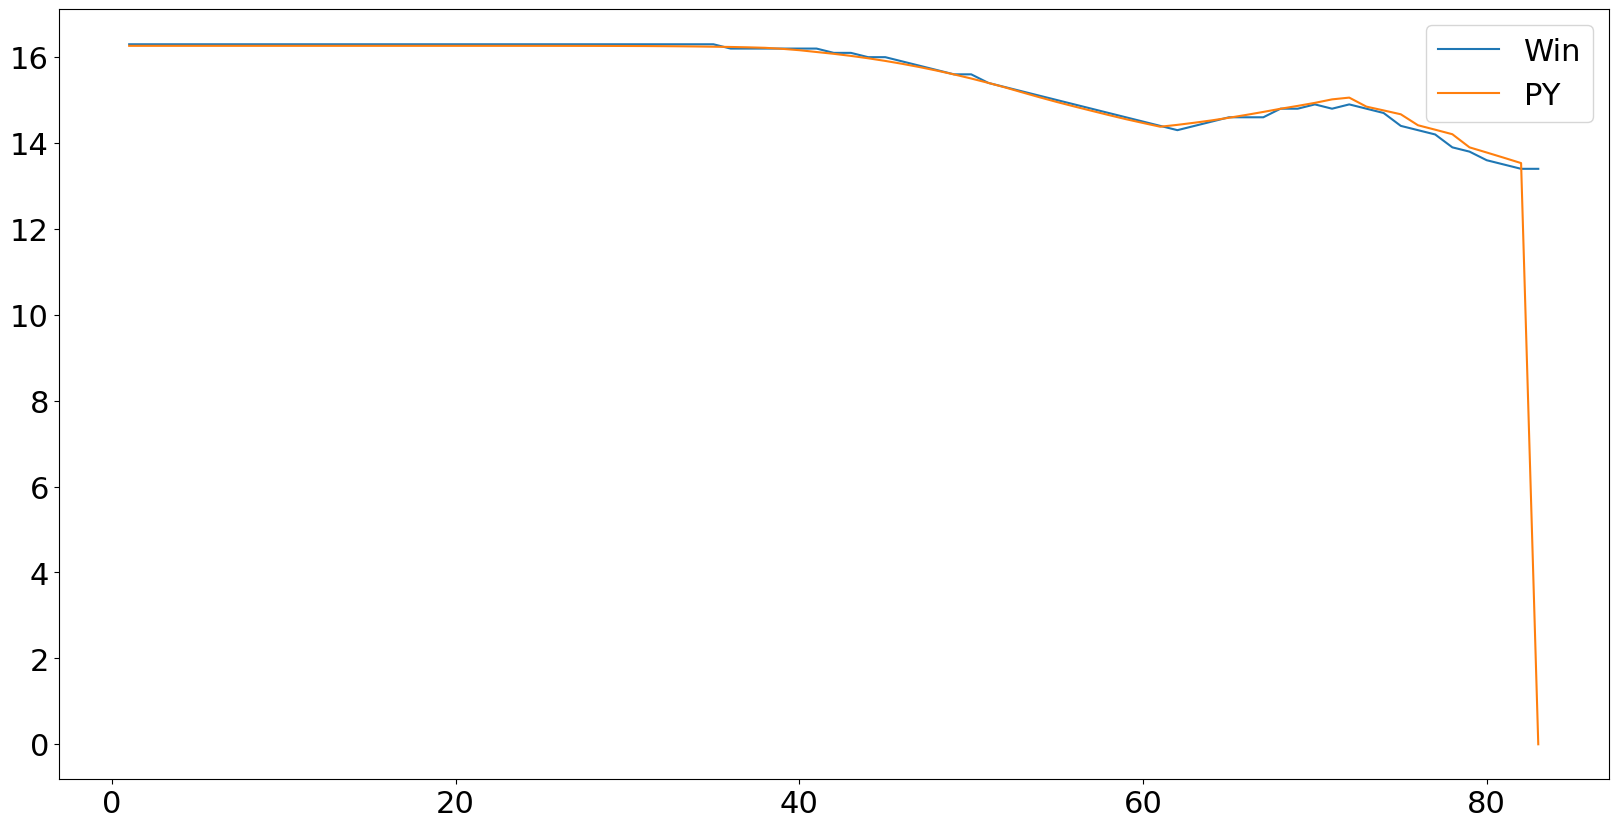

In [8]:
aq=pd.read_table('AquaCropV71No13102023\SIMUL\Crop.OUT',skiprows=4, delim_whitespace=True,encoding="latin1")
aq=aq.drop([0])

aq.to_csv('aq_temp.csv')

aq=pd.read_csv('aq_temp.csv')

import matplotlib.pyplot as plt

aq

time=np.array(range(1,len(aq.index)))
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'CC'],label='Win')
plt.plot(time,model_results.loc[time,'canopy_cover']*100,label='PY')
plt.plot(time,aq.loc[time,'CC']-model_results.loc[time,'canopy_cover']*100,label='Diff')
plt.legend()
plt.savefig('test_figs\potato_CCx_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Biomass'],label='Win')
plt.plot(time,model_results.loc[time,'biomass']/100,label='PY')
plt.legend()
plt.savefig('test_figs\potato_Biomass_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Tr'],label='Win')
plt.plot(time,model_results.loc[time,'Tr'],label='PY')
plt.legend()

import itertools
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,list(itertools.accumulate(aq.loc[time,'Tr'])),label='Win')
plt.plot(time,list(itertools.accumulate(model_results.loc[time,'Tr'])),label='PY')
plt.legend()
plt.savefig('test_figs\potato_Traccum_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

#time=range(1,175)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'WP'],label='Win')
plt.plot(time,model_results.loc[time,'NewCond.WPadj'],label='PY')
plt.legend()
plt.savefig('test_figs\potato_WPadj_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

In [6]:
aq=pd.read_table('AquaCropV61Nr02052018\SIMUL\Crop.OUT',skiprows=4, delim_whitespace=True,encoding="latin1")
aq=aq.drop([0])

aq.to_csv('aq_temp.csv')

aq=pd.read_csv('aq_temp.csv')

import matplotlib.pyplot as plt

aq

time=np.array(range(1,len(aq.index)))
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'CC'],label='Win')
plt.plot(time,model_results.loc[time,'canopy_cover']*100,label='PY')
plt.plot(time,aq.loc[time,'CC']-model_results.loc[time,'canopy_cover']*100,label='Diff')
plt.legend()
plt.savefig('test_figsv6\potato_CCx_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Biomass'],label='Win')
plt.plot(time,model_results.loc[time,'biomass']/100,label='PY')
plt.legend()
plt.savefig('test_figsv6\potato_Biomass_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,aq.loc[time,'Tr'],label='Win')
plt.plot(time,model_results.loc[time,'Tr'],label='PY')
plt.legend()

import itertools
plt.figure()
plt.figure(figsize=(20,10))
plt.plot(time,list(itertools.accumulate(aq.loc[time,'Tr'])),label='Win')
plt.plot(time,list(itertools.accumulate(model_results.loc[time,'Tr'])),label='PY')
plt.legend()
plt.savefig('test_figsv6\potato_Traccum_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

#time=range(1,175)
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(time,aq.loc[time,'WP'],label='Win')
plt.plot(time,model_results.loc[time,'NewCond.WPadj'],label='PY')
plt.legend()
plt.savefig('test_figsv6\potato_WPadj_irrmethod{0}_stress{1}.png'.format(IrrMethod,stress))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'AquaCropV61Nr02052018\\SIMUL\\Crop.OUT'